> Base Pytorch Code:
https://www.kaggle.com/piantic/how-to-finetuning-models-pytorch-xla-tpu

> Augmentations from:
https://www.kaggle.com/capiru/cassavanet-cutmix-implementation-cv-0-9#Augmentations

In [1]:
class CFG:
    debug=False
    device='cuda:0' # ['TPU', 'GPU', 'cpu']
    nprocs=1 # [1, 8]
    num_workers=4
    model_name='vit_base_patch32_384' # ['deit_base_patch16_224', 'vit_base_patch16_384', 'resnext50_32x4d', 'tf_efficientnet_b3_ns']
    size=384  # [64, 128, 224, 384, 512]
    train=True
    freeze=False
    freeze_epo = 1 # after these epochs, gradually unfreeze top layers
    gradual_unfreez_epo = 7
    epochs = 1 # freeze_epo + gradual_unfreez_epo 
    epochs3x = 4
    min_unfreez_layer = 2 # allowed to unfreeze layers 11 to 5 only and not less than 5
    max_layer_no = 11 # for ViT
    criterion='CrossEntropyLoss' # ['CrossEntropyLoss', LabelSmoothing', 'FocalLoss' 'FocalCosineLoss', 'SymmetricCrossEntropyLoss', 'BiTemperedLoss', 'TaylorCrossEntropyLoss']
    T_0=10 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=10 #[32, 64]
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1
    tta=3 # RandAugment 
    seed=42
    target_size=5
    target_col='label'
    n_fold=5
    train_fold=[0] #, 1, 2, 3, 4]
    # infer_fold=[0, 1, 2, 3, 4]
    smoothing=0.1
    t1=0.3 # bi-tempered-loss https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/202017
    t2=1.0 # bi-tempered-loss https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/202017
    model_infer_path_prefix = "." #"../input/tf-efficientnet-b4-ns-88"
    model_train_path_prefix = "."
    train_path = '../input/cassava-leaf-disease-classification/train_images'
    train_csv  = '../input/cassava-leaf-disease-classification/train.csv'
    test_path  = '../input/cassava-leaf-disease-classification/test_images'
    test_csv   = '../input/cassava-leaf-disease-classification/test.csv'
    output_dir = 'Output/'
    
    IMG_MEAN = [0.485, 0.456, 0.406] #Mean for normalization Transform cassava = [0.4303, 0.4967, 0.3134] imgnet = [0.485, 0.456, 0.406]
    IMG_STD = [0.229, 0.224, 0.225] #STD for normalization Transform cassava = [0.2142, 0.2191, 0.1954] imgnet = [0.229, 0.224, 0.225]
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

In [2]:
import os
import gc
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from   torch.nn import CrossEntropyLoss, MSELoss
from   torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
from   torch.nn import Parameter
import math

import fastai
from   fastai.callback.mixup import MixUp, CutMix
from   fastai.callback import *
from   fastai.callback.all import *
from   fastai.callback.training import GradientClip
from   fastai.callback.all import SaveModelCallback, EarlyStoppingCallback, ReduceLROnPlateau 
from   fastai.data.core import *
from   fastai.data.load import *
from   fastai.learner import Learner
from   fastai.metrics import *
from   fastai.optimizer import OptimWrapper 
from   fastai.losses import LabelSmoothingCrossEntropy

# from   warmup_scheduler import GradualWarmupScheduler
from   sklearn import preprocessing
from   sklearn.metrics import accuracy_score
from   sklearn.model_selection import StratifiedKFold

import timm
import albumentations as A
from   albumentations.pytorch import ToTensorV2
from   albumentations.core.transforms_interface import DualTransform
from   albumentations.augmentations import functional as AF
import cv2

from   tqdm import tqdm
from   pprint import pprint
from   functools import partial
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings ("ignore")

In [3]:
DEVICE = torch.device ('cuda:0' if torch.cuda.is_available () else 'cpu')

In [4]:
def init_logger (log_file=CFG.output_dir+'train.log'):
    
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger (__name__)
    logger.setLevel (INFO)
    handler1 = StreamHandler ()
    handler1.setFormatter (Formatter ("%(message)s"))
    handler2 = FileHandler (filename=log_file)
    handler2.setFormatter (Formatter ("%(message)s"))
    logger.addHandler (handler1)
    logger.addHandler (handler2)
    return logger

In [5]:
def seed_everything (seed):
    
    random.seed (seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed (seed)
    torch.manual_seed (seed)
    torch.cuda.manual_seed (seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    return

In [6]:
class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.
    
    Author: Qishen Ha
    Email: haqishen@gmail.com
    2020/01/29

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=5, fill_value=0, rotate=0, mode=0, always_apply=False, mask_shrink=3, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []
        self.mask_shrink = mask_shrink
        return

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / self.mask_shrink),
                             int(j * grid_w) : int(j * grid_w + grid_w / self.mask_shrink)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / self.mask_shrink) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / self.mask_shrink) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = AF.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        # height, width = height//2, width//2
        
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')


In [7]:
# ====================================================
# Augmentations
# ====================================================

Aug_Norm    = A.Normalize(mean=CFG.IMG_MEAN, std=CFG.IMG_STD, max_pixel_value=255.0, p=1.0)
Drop_Rand   = A.CoarseDropout(max_holes=12, max_height=int(0.11*CFG.size), max_width=int(0.11*CFG.size),
                            min_holes=1, min_height=int(0.03*CFG.size), min_width=int(0.03*CFG.size),
                            always_apply=False, p=0.5)
Rand_Crop   = A.RandomCrop(height= CFG.size, width = CFG.size,always_apply=True, p=1.0)
Resize_Crop = A.RandomResizedCrop(CFG.size, CFG.size,p=1.0)
grid_Mask   = A.OneOf ([
            GridMask (mask_shrink=2.8),
            GridMask (mask_shrink=3.0),
            GridMask (mask_shrink=3.2),
], p=0.5)
train_transforms = A.Compose ([
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5),
            A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            A.RandomBrightnessContrast (
                    brightness_limit=(-0.1,0.1), 
                    contrast_limit=(-0.1, 0.1), 
                    p=0.5
                ),
            Resize_Crop,
            Drop_Rand,           
            Aug_Norm, 
            grid_Mask,
            ToTensorV2(p=1.0),
        ], p=1.)

light_transforms = A.Compose([
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5),
            A.HueSaturationValue(
                        hue_shift_limit=0.2, 
                        sat_shift_limit=0.2, 
                        val_shift_limit=0.2, 
                        p=0.5),
            A.RandomBrightnessContrast(
                            brightness_limit=(-0.1,0.1), 
                            contrast_limit=(-0.1, 0.1), 
                            p=0.5),
            Resize_Crop,
            Aug_Norm, 
            grid_Mask,
            ToTensorV2(p=1.0),
        ], p=1.)

heavy_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    
    A.Resize(CFG.size, CFG.size),
    
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    #A.augmentations.transforms.ColorJitter(brightness=0.10, contrast=0.2, saturation=0.2, hue=0.00, always_apply=False, p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.augmentations.transforms.RGBShift (r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.5),
    A.augmentations.transforms.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=0.5),
    
    A.augmentations.transforms.GridDistortion (num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5),
    Aug_Norm,
    grid_Mask,
    ToTensorV2(p=1.0),])

valid_transforms = A.Compose([
            A.CenterCrop(CFG.size, CFG.size),
            Aug_Norm,   
            ToTensorV2(p=1.0),
        ], p=1.)

test_aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p = 1.0),
            #A.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.00, always_apply=False, p=1.0),
            Rand_Crop,
            Aug_Norm,
            ToTensorV2(p=1.0)
        ], p=1.)

image_net_post = A.Compose([
            Resize_Crop,
            Drop_Rand,
            Aug_Norm,    
            ToTensorV2(p=1.0)
        ], p=1.)

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
def get_transforms (data='train', size=CFG.size):
    
    if 'train' in data:
        return train_transforms # heavy_transforms # light_transforms
    elif 'valid' in data:
        return valid_transforms
    else:
        return valid_transforms

In [8]:
# Datasets: Fastai DS for training and Pytorch DS for inference

In [9]:
class CassavaDataset (Datasets):
    
    def __init__(self, df, transform=get_transforms(), path=CFG.train_path, isLabel=True):
        
        super (CassavaDataset, self).__init__(df, tfms=None, n_inp=1) 
        self.file_names = df['image_id'].values
        self.transform  = transform
        self.path       = path
        self.isLabel    = isLabel
        if isLabel:
            self.labels = df['label'].values
        return
        
    def __len__(self):        
        return 10 # len (self.items)    # TODO: fix this

    def __getitem__(self, idx):
        
        file_name = self.file_names[idx]
        file_path = f'{self.path}/{file_name}'
        image     = cv2.imread (file_path)
        image     = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform (image=image)
            image = augmented['image']
        
        if self.isLabel:
            label = torch.tensor (self.labels[idx]).float () # long ()
            return image, label
        return image

In [10]:
def getFolds ():
    
    train_folds_df = pd.read_csv (CFG.train_csv)
    skf = StratifiedKFold (n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate (skf.split (train_folds_df, train_folds_df[CFG.target_col])):
        train_folds_df.loc[val_index, 'fold'] = int (n)
    train_folds_df['fold'] = train_folds_df['fold'].astype (int)
    # print (train_folds_df.groupby (['fold', CFG.target_col]).size ())
    return train_folds_df

In [11]:
# Test your Dataset and Dataloader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

63

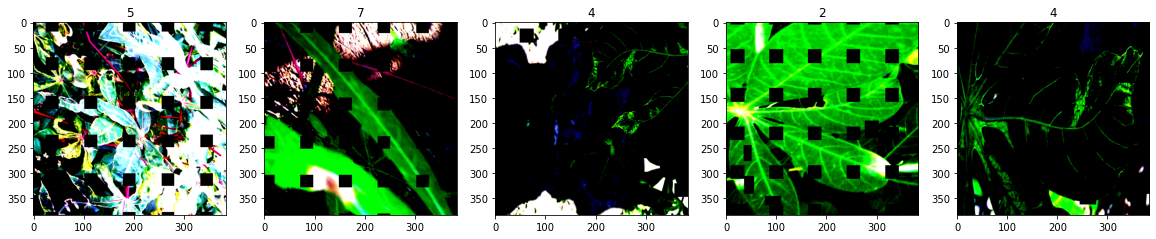

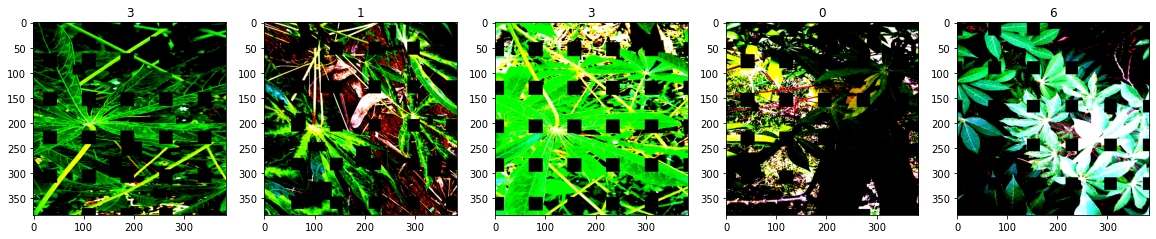

In [12]:
def plot_imgs (dataset_show):
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,10
    for i in range(2):
        f, axarr = plt.subplots(1,5)
        for p in range(5):
            idx = np.random.randint(0, len(dataset_show))
            img, label = dataset_show[idx]
            axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
            axarr[p].set_title(idx)
    return

TR_DATASET = CassavaDataset (getFolds ())
plot_imgs (TR_DATASET)
del TR_DATASET
gc.collect ()

# Losses

> Label Smoothing

In [13]:
# ====================================================
# Label Smoothing
# ====================================================
class LabelSmoothingLoss(nn.Module): 
    def __init__(self, classes=5, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 
        
    def forward(self, pred, target): 
        pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad():
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

> FocalLoss

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss


> FocalCosineLoss

In [15]:
class FocalCosineLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, xent=.1):
        super(FocalCosineLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

        self.xent = xent

        self.y = torch.Tensor([1]).cuda()

    def forward(self, input, target, reduction="mean"):
        cosine_loss = F.cosine_embedding_loss(input, F.one_hot(target, num_classes=input.size(-1)), self.y, reduction=reduction)

        cent_loss = F.cross_entropy(F.normalize(input), target, reduce=False)
        pt = torch.exp(-cent_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * cent_loss

        if reduction == "mean":
            focal_loss = torch.mean(focal_loss)

        return cosine_loss + self.xent * focal_loss

> SymmetricCrossEntropy

In [16]:
class SymmetricCrossEntropy(nn.Module):

    def __init__(self, alpha=0.1, beta=1.0, num_classes=5):
        super(SymmetricCrossEntropy, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes

    def forward(self, logits, targets, reduction='mean'):
        onehot_targets = torch.eye(self.num_classes)[targets].cuda()
        ce_loss = F.cross_entropy(logits, targets, reduction=reduction)
        rce_loss = (-onehot_targets*logits.softmax(1).clamp(1e-7, 1.0).log()).sum(1)
        if reduction == 'mean':
            rce_loss = rce_loss.mean()
        elif reduction == 'sum':
            rce_loss = rce_loss.sum()
        return self.alpha * ce_loss + self.beta * rce_loss

> Bi-Tempered-Loss

In [17]:
def log_t(u, t):
    """Compute log_t for `u'."""
    if t==1.0:
        return u.log()
    else:
        return (u.pow(1.0 - t) - 1.0) / (1.0 - t)

def exp_t(u, t):
    """Compute exp_t for `u'."""
    if t==1:
        return u.exp()
    else:
        return (1.0 + (1.0-t)*u).relu().pow(1.0 / (1.0 - t))

def compute_normalization_fixed_point(activations, t, num_iters):

    """Returns the normalization value for each example (t > 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same shape as activation with the last dimension being 1.
    """
    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations_step_0 = activations - mu

    normalized_activations = normalized_activations_step_0

    for _ in range(num_iters):
        logt_partition = torch.sum(
                exp_t(normalized_activations, t), -1, keepdim=True)
        normalized_activations = normalized_activations_step_0 * \
                logt_partition.pow(1.0-t)

    logt_partition = torch.sum(
            exp_t(normalized_activations, t), -1, keepdim=True)
    normalization_constants = - log_t(1.0 / logt_partition, t) + mu

    return normalization_constants

def compute_normalization_binary_search(activations, t, num_iters):

    """Returns the normalization value for each example (t < 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (< 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """

    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations = activations - mu

    effective_dim = \
        torch.sum(
                (normalized_activations > -1.0 / (1.0-t)).to(torch.int32),
            dim=-1, keepdim=True).to(activations.dtype)

    shape_partition = activations.shape[:-1] + (1,)
    lower = torch.zeros(shape_partition, dtype=activations.dtype, device=activations.device)
    upper = -log_t(1.0/effective_dim, t) * torch.ones_like(lower)

    for _ in range(num_iters):
        logt_partition = (upper + lower)/2.0
        sum_probs = torch.sum(
                exp_t(normalized_activations - logt_partition, t),
                dim=-1, keepdim=True)
        update = (sum_probs < 1.0).to(activations.dtype)
        lower = torch.reshape(
                lower * update + (1.0-update) * logt_partition,
                shape_partition)
        upper = torch.reshape(
                upper * (1.0 - update) + update * logt_partition,
                shape_partition)

    logt_partition = (upper + lower)/2.0
    return logt_partition + mu

class ComputeNormalization(torch.autograd.Function):
    """
    Class implementing custom backward pass for compute_normalization. See compute_normalization.
    """
    @staticmethod
    def forward(ctx, activations, t, num_iters):
        if t < 1.0:
            normalization_constants = compute_normalization_binary_search(activations, t, num_iters)
        else:
            normalization_constants = compute_normalization_fixed_point(activations, t, num_iters)

        ctx.save_for_backward(activations, normalization_constants)
        ctx.t=t
        return normalization_constants

    @staticmethod
    def backward(ctx, grad_output):
        activations, normalization_constants = ctx.saved_tensors
        t = ctx.t
        normalized_activations = activations - normalization_constants 
        probabilities = exp_t(normalized_activations, t)
        escorts = probabilities.pow(t)
        escorts = escorts / escorts.sum(dim=-1, keepdim=True)
        grad_input = escorts * grad_output
        
        return grad_input, None, None

def compute_normalization(activations, t, num_iters=5):
    """Returns the normalization value for each example. 
    Backward pass is implemented.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """
    return ComputeNormalization.apply(activations, t, num_iters)

def tempered_sigmoid(activations, t, num_iters = 5):
    """Tempered sigmoid function.
    Args:
      activations: Activations for the positive class for binary classification.
      t: Temperature tensor > 0.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_probabilities = tempered_softmax(internal_activations, t, num_iters)
    return internal_probabilities[..., 0]


def tempered_softmax(activations, t, num_iters=5):
    """Tempered softmax function.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature > 1.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    if t == 1.0:
        return activations.softmax(dim=-1)

    normalization_constants = compute_normalization(activations, t, num_iters)
    return exp_t(activations - normalization_constants, t)

def bi_tempered_binary_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing = 0.0,
        num_iters=5,
        reduction='mean'):

    """Bi-Tempered binary logistic loss.
    Args:
      activations: A tensor containing activations for class 1.
      labels: A tensor with shape as activations, containing probabilities for class 1
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing
      num_iters: Number of iterations to run the method.
    Returns:
      A loss tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_labels = torch.stack([labels.to(activations.dtype),
        1.0 - labels.to(activations.dtype)],
        dim=-1)
    return bi_tempered_logistic_loss(internal_activations, 
            internal_labels,
            t1,
            t2,
            label_smoothing = label_smoothing,
            num_iters = num_iters,
            reduction = reduction)

def bi_tempered_logistic_loss(activations,
        labels,
        t1=0.6,
        t2=1.6,
        label_smoothing=0.2,
        num_iters=5,
        reduction = 'mean'):

    """Bi-Tempered Logistic Loss.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      labels: A tensor with shape and dtype as activations (onehot), 
        or a long tensor of one dimension less than activations (pytorch standard)
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing parameter between [0, 1). Default 0.0.
      num_iters: Number of iterations to run the method. Default 5.
      reduction: ``'none'`` | ``'mean'`` | ``'sum'``. Default ``'mean'``.
        ``'none'``: No reduction is applied, return shape is shape of
        activations without the last dimension.
        ``'mean'``: Loss is averaged over minibatch. Return shape (1,)
        ``'sum'``: Loss is summed over minibatch. Return shape (1,)
    Returns:
      A loss tensor.
    """

    if len(labels.shape)<len(activations.shape): #not one-hot
        labels_onehot = torch.zeros_like(activations)
        labels_onehot.scatter_(1, labels[..., None], 1)
    else:
        labels_onehot = labels

    if label_smoothing > 0:
        num_classes = labels_onehot.shape[-1]
        labels_onehot = ( 1 - label_smoothing * num_classes / (num_classes - 1) ) \
                * labels_onehot + \
                label_smoothing / (num_classes - 1)

    probabilities = tempered_softmax(activations, t2, num_iters)

    loss_values = labels_onehot * log_t(labels_onehot + 1e-10, t1) \
            - labels_onehot * log_t(probabilities, t1) \
            - labels_onehot.pow(2.0 - t1) / (2.0 - t1) \
            + probabilities.pow(2.0 - t1) / (2.0 - t1)
    loss_values = loss_values.sum(dim = -1) #sum over classes

    if reduction == 'none':
        return loss_values
    if reduction == 'sum':
        return loss_values.sum()
    if reduction == 'mean':
        return loss_values.mean()
    

class BiTemperedLogisticLoss(nn.Module): 
    def __init__(self, t1=0.6, t2=1.6, smoothing=0.2): 
        super(BiTemperedLogisticLoss, self).__init__() 
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing
    def forward(self, logit_label, truth_label):
        loss_label = bi_tempered_logistic_loss(
            logit_label, truth_label,
            t1=self.t1, t2=self.t2,
            label_smoothing=self.smoothing,
            reduction='none'
        )
        
        loss_label = loss_label.mean()
        return loss_label

> TaylorCrossEntropyLoss with LabelSmoothing

In [18]:
class TaylorSoftmax(nn.Module):
    '''
    This is the autograd version
    '''
    def __init__(self, dim=1, n=2):
        super(TaylorSoftmax, self).__init__()
        assert n % 2 == 0
        self.dim = dim
        self.n = n

    def forward(self, x):
        '''
        usage similar to nn.Softmax:
            >>> mod = TaylorSoftmax(dim=1, n=4)
            >>> inten = torch.randn(1, 32, 64, 64)
            >>> out = mod(inten)
        '''
        fn = torch.ones_like(x)
        denor = 1.
        for i in range(1, self.n+1):
            denor *= i
            fn = fn + x.pow(i) / denor
        out = fn / fn.sum(dim=self.dim, keepdims=True)
        return out


class TaylorCrossEntropyLoss (nn.Module):

    def __init__(self, n=2, ignore_index=-1, reduction='mean', smoothing=0.2):
        super(TaylorCrossEntropyLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.lab_smooth = LabelSmoothingLoss(CFG.target_size, smoothing=smoothing)

    def forward(self, logits, labels):
        log_probs = self.taylor_softmax(logits).log()
        loss = self.lab_smooth(log_probs, labels)
        return loss

In [19]:
def get_criterion ():
    
    if CFG.criterion=='CrossEntropyLoss':
        criterion = LabelSmoothingCrossEntropy ()  # nn.CrossEntropyLoss ()
    elif CFG.criterion=='LabelSmoothing':
        criterion = LabelSmoothingLoss(classes=CFG.target_size, smoothing=CFG.smoothing)
    elif CFG.criterion=='FocalLoss':
        criterion = FocalLoss().to(device)
    elif CFG.criterion=='FocalCosineLoss':
        criterion = FocalCosineLoss()
    elif CFG.criterion=='SymmetricCrossEntropyLoss':
        criterion = SymmetricCrossEntropy().to(device)
    elif CFG.criterion=='BiTemperedLoss':
        criterion = BiTemperedLogisticLoss(t1=CFG.t1, t2=CFG.t2, smoothing=CFG.smoothing)
    elif CFG.criterion=='TaylorCrossEntropyLoss':
        criterion = TaylorCrossEntropyLoss(smoothing=CFG.smoothing)
    return criterion

# Models

In [20]:
# ====================================================
# MODEL
# ====================================================
class CustomResNext(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.fc.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
            

class CustomEfficientNet(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(CFG.model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
        
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.classifier.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
    
    
class CustomDeiT(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/deit:main', model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.head.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True

    
class CustomViT(nn.Module):
    
    def __init__(self, model_name=CFG.model_name, pretrained=False, 
                 min_unfreez_layer=CFG.min_unfreez_layer, max_layer_no=CFG.max_layer_no):
        
        super().__init__()
        self.model      = timm.create_model(model_name, pretrained=pretrained)
        n_features      = self.model.head.in_features
        self.model.head = nn.Linear(n_features, CFG.target_size)
        self.min_unfreez_layer = min_unfreez_layer
        self.max_layer_no      = max_layer_no
        return

    def forward(self, x):
        x = self.model(x)
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.head.parameters():
            param.requires_grad = True
        return
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
        return
    
    def unfreeze_layer (self, layer_no=11):
        # unfreeze a particular layer
        if layer_no >= self.min_unfreez_layer and layer_no <= self.max_layer_no:
            for param in self.model.blocks[layer_no].parameters ():
                param.requires_grad = False
        return

In [21]:
def load_state (model_path, model):
    
    state_dict = None
    try:  # single GPU model_file
        model.load_state_dict (torch.load (model_path, map_location=torch.device ('cpu')), strict=True)
        state_dict = torch.load (model_path)['model']
    except:  # multi GPU model_file
        state_dict = torch.load (model_path, map_location=torch.device ('cpu'))
        state_dict = {k[7:] if k.startswith ('module.') else k: state_dict[k] for k in state_dict.keys ()}
        model.load_state_dict (state_dict)
    return state_dict

In [22]:
def getModel (fold, isTrain=True):
    
    model = None
    if 'deit_' in CFG.model_name:
        model = CustomDeiT (model_name=CFG.model_name, pretrained=isTrain)
    elif 'vit_' in CFG.model_name:
        model = CustomViT (model_name=CFG.model_name, pretrained=isTrain)
    elif 'resnext' in CFG.model_name:
        model = CustomResNext (CFG.model_name, pretrained=isTrain)
    elif 'efficientnet' in CFG.model_name:
        model = CustomEfficientNet (CFG.model_name, pretrained=isTrain)   # TODO pretrained=isTrain    
    if isTrain:
        
        model_path = f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_maxacc.pth'
        if os.path.exists (model_path):
          load_state (model_path, model)  
        # TODO: comment this
        # model_path = f'{CFG.model_infer_path_prefix}/{CFG.model_name}_fold{fold}.pth'
        # load_state (model_path, model)
        # torch.save (model.state_dict (), f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}.pth')
    else:
        
        # TODO: change CFG.model_train_path_prefix to CFG.model_infer_path_prefix
        model_path = f'{CFG.model_infer_path_prefix}/{CFG.model_name}_fold{fold}_maxacc.pth'
        load_state (model_path, model)
        
    if CFG.freeze:        
        model.freeze ()
    else:
        model.unfreeze ()
    return model

In [23]:
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates (subplots)
def plot_metrics (self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil (n / ncols))
    elif ncols is None: ncols = int(np.ceil (n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots (nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate (axs.flatten())][:n]
    for i, (name, ax) in enumerate (zip (names, [axs[0]] + axs)):
        ax.plot (metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title (name if i > 1 else 'losses')
        ax.legend (loc='best')
    plt.show ()

In [24]:
@delegates (torch.optim.AdamW.__init__)
def pytorch_AdamW (param_groups, **kwargs):
    return OptimWrapper (torch.optim.AdamW ([{'params': ps, **kwargs} for ps in param_groups]))

In [25]:
class UnfreezeCallback (Callback):
    
    def __init__(self, freeze_epo=CFG.freeze_epo, max_layer_no=CFG.max_layer_no):
        super().__init__()
        self.freeze_epo   = freeze_epo
        self.max_layer_no = max_layer_no
        return
        
    def before_epoch (self): 
        if self.epoch >= self.freeze_epo:
            self.learn.model.unfreeze_layer (self.max_layer_no - (self.epoch-self.freeze_epo))

In [26]:
def fit_epochs (fold, callbacks, learn, max_acc, start_lr=1e-6, end_lr=5e-5):
    
    # lr_min = 1e-5
    lr_min, _   = learn.lr_find (start_lr=start_lr, end_lr=end_lr, num_it=100) 
    print ('lr_min =', lr_min)
    lr          = lr_min
    model       = getModel (fold, isTrain=True).to (DEVICE)
    learn.model = model
    learn.fit_one_cycle (CFG.epochs, lr, wd=CFG.weight_decay, cbs=callbacks)
    learn.recorder.plot_metrics ()
    # learn.recorder.plot_lr ()        
    acc = learn.recorder.metrics[0].value.numpy ()
    if acc > max_acc:
        max_acc = acc
        learn.save (f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_maxacc')
    return max_acc

In [27]:
def train_fold_loop (fold, train_df=getFolds ()):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = train_df[train_df['fold'] != fold].index
    val_idx = train_df[train_df['fold'] == fold].index

    train_folds_df = train_df.loc[trn_idx].reset_index (drop=True)
    valid_folds_df = train_df.loc[val_idx].reset_index (drop=True)    
    loss_func = get_criterion ()
    model     = getModel (fold, isTrain=True)
    # device  = torch.device (CFG.device)
    model     = model.to (DEVICE)
    modelfile = f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}'
    size          = CFG.size
    train_dataset = CassavaDataset (train_folds_df, transform=get_transforms ('train', size))
    valid_dataset = CassavaDataset (valid_folds_df, transform=get_transforms ('valid', size))
    train_datlder = DataLoader (train_dataset, batch_size=CFG.batch_size, device=DEVICE)
    valid_datlder = DataLoader (valid_dataset, batch_size=CFG.batch_size, device=DEVICE)
    dls           = DataLoaders (train_datlder, valid_datlder, device=DEVICE)
    learn         = Learner (dls, model, loss_func=loss_func, model_dir=f'{CFG.model_train_path_prefix}',
                     opt_func=partial (pytorch_AdamW, lr=0.007, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01),
                     metrics=[accuracy, error_rate])   #fbeta, auc_roc_score
    # print (learn.summary ())
    
    max_acc = 0
    lr_min = 1e-5  # TODO: remove this
    for i in range (CFG.epochs3x):
        
        if i < 2:
            start_lr, end_lr = 1e-5, 5e-4
        else:
            start_lr, end_lr = 1e-6, 5e-5
            
        # 1st round
        callbacks = [
            EarlyStoppingCallback (monitor='accuracy', min_delta=0.0001, patience=12),
            SaveModelCallback     (monitor='accuracy', fname=modelfile),
            ReduceLROnPlateau     (monitor='accuracy', min_delta=0.0001, factor=2.0, min_lr=1e-8, patience=1),
            GradientClip (CFG.max_grad_norm),
            # MixUp (),
            CutMix (),
        ]     
        max_acc = fit_epochs (fold, callbacks, learn, max_acc, start_lr, end_lr)
            
        # 2nd round
        callbacks = [
            EarlyStoppingCallback (monitor='accuracy', min_delta=0.0001, patience=12),
            SaveModelCallback     (monitor='accuracy', fname=modelfile),
            ReduceLROnPlateau     (monitor='accuracy', min_delta=0.0001, factor=2.0, min_lr=1e-8, patience=1),
            GradientClip (CFG.max_grad_norm),
            # UnfreezeCallback (),
            MixUp (),
            CutMix (),
        ]     
        max_acc = fit_epochs (fold, callbacks, learn, max_acc, start_lr, end_lr)
            
        # 3rd round
        callbacks = [
            EarlyStoppingCallback (monitor='accuracy', min_delta=0.0001, patience=12),
            SaveModelCallback     (monitor='accuracy', fname=modelfile),
            ReduceLROnPlateau     (monitor='accuracy', min_delta=0.0001, factor=2.0, min_lr=1e-8, patience=1),
            GradientClip (CFG.max_grad_norm),
            MixUp (),
            # CutMix (),
        ]
        max_acc = fit_epochs (fold, callbacks, learn, max_acc, start_lr, end_lr)
            
    return valid_scores

In [28]:
def train_main ():
    
    if CFG.train:
        # train 
        valid_scores = []
        for fold in range (CFG.n_fold):
            if fold in CFG.train_fold:
                valid_scores_fold = train_fold_loop (fold)
                valid_scores_fold = np.array (valid_scores_fold).reshape ((1, -1))
                valid_scores.append (valid_scores_fold)
                
        LOGGER.info (f"========== CV ==========")
        valid_scores = np.vstack (valid_scores)
        valid_scores = np.mean (valid_scores, axis=0)
        print ("CV Scores =", valid_scores)

# Train Main

In [29]:
gc.collect ()
# model_names = timm.list_models (pretrained=True)
model_names = timm.list_models ('vit_*', pretrained=True)
pprint (model_names)

['vit_base_patch16_224',
 'vit_base_patch16_384',
 'vit_base_patch32_384',
 'vit_large_patch16_224',
 'vit_large_patch16_384',
 'vit_large_patch32_384',
 'vit_small_patch16_224']


In [30]:
!mkdir -p /kaggle/working/Output/
!touch /kaggle/working/Output/train.log

The syntax of the command is incorrect.
'touch' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
LOGGER = init_logger ()
seed_everything (seed=CFG.seed)
train_main ()

========== fold: 0 training ==========


# Inference

In [ ]:
def compute_metrics (labels, preds):
    
    # preds   = pred_pr.argmax (-1)             # ;print ('labels.shape=', labels.shape, 'preds.shape=', preds.shape, 'pred_logits.shape=', pred_logits.shape)
    precision, recall, f1, _ = precision_recall_fscore_support (labels, preds, average='macro')
    acc     = accuracy_score (labels, preds)
    mcc     = matthews_corrcoef (labels, preds)   # matthews correlation coefficient
    # softmax = nn.Softmax (dim=1)
    # pred_pr = softmax (torch.tensor (pred_logits))
    # auc     = roc_auc_score (labels, pred_pr[:, 1])
    metrics = {
        'mcc'      : mcc,
        'accuracy' : acc,
        'f1'       : f1,
        'precision': precision,
        'recall'   : recall,
        #'auc'     : auc
    }
    return metrics

In [ ]:
class TorchCassavaDataset (torch.utils.data.Dataset):
    
    def __init__(self, df, transform=get_transforms('valid'), path=CFG.test_path, isLabel=False):
        
        super ().__init__()
        self.df         = df
        self.file_names = df['image_id'].values
        self.transform  = transform
        self.path       = path
        self.isLabel    = isLabel
        if isLabel:
            self.labels = df['label'].values
        return
        
    def __len__(self):        
        return self.df.shape[0]

    def __getitem__(self, idx):
        
        file_name = self.file_names[idx]
        file_path = f'{self.path}/{file_name}'
        image     = cv2.imread (file_path)
        image     = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform (image=image)
            image     = augmented['image']
        
        if self.isLabel:
            label = torch.tensor (self.labels[idx]).long ()
            return image, label
        return image

In [ ]:
def inference_one_loop (model, data_loader, device):
    model.eval ()
    image_preds_all = []
    pbar = tqdm (enumerate (data_loader), total=len (data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to (device).float ()
        
        image_preds = model (imgs) 
        image_preds_all += [torch.softmax (image_preds, 1).detach ().cpu ().numpy ()]
    
    image_preds_all = np.concatenate (image_preds_all, axis=0)
    return image_preds_all

In [ ]:
def infer ():
    
    CFG.freeze = True
    tst_preds_avg = []    
    seed_everything (CFG.seed)
    test_df = pd.DataFrame ()
    test_df['image_id'] = list (os.listdir (CFG.test_path))
    test_ds = TorchCassavaDataset (test_df)             #;print ('len (test_ds) =', len (test_ds)) ;print ('test_ds[10].shape =', test_ds[10].shape)
    tst_loader = torch.utils.data.DataLoader (
        test_ds, 
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=False,
        pin_memory=False,
    )                                            #;print ('len (tst_loader)=', len (tst_loader))
    device = DEVICE  # torch.device (CFG.device)
    for fold in CFG.train_fold:
        
        print ('Inference fold {} started'.format (fold))
        model     = getModel (fold, isTrain=False).to (device)
        tst_preds = []        
        with torch.no_grad ():
            for _ in range (CFG.tta):
                
                tst_preds += [1/CFG.tta * inference_one_loop (model, tst_loader, device)]
        
        tst_preds_avg.append (np.mean (tst_preds, axis=0))
        del model
        torch.cuda.empty_cache ()
        gc.collect ()
    
    test_df['label'] = np.argmax (np.mean (tst_preds_avg, axis=0), axis=-1)
    print (test_df.head ())
    test_df.to_csv ('submission.csv', index=False)

In [ ]:
LOGGER = init_logger ()
seed_everything (seed=CFG.seed)
infer ()

In [ ]:
print ('Done !')